### Установка нужных библиотек


In [ ]:
! pip install face-alignment colormath extcolors

----

### Подгружаем параметры для `dlib`

In [ ]:
! wget https://github.com/justadudewhohacks/face-recognition.js-models/raw/master/models/mmod_human_face_detector.dat

In [ ]:
! wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

----

### Импорты

In [ ]:
import numpy as np
import pandas as pd

import dlib
import cv2
import face_alignment
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from PIL import Image
import extcolors

from os import listdir
from os.path import isfile, join
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

----

### Класс для извлечения макияжа

(Версия, где можно выбрать, отдельно обрабатывать глаза и губы или вместе)

In [ ]:
class ExtractMakeup:
    def __init__(self, use_cnn_face_detector=False):
        # define landmarks numbers for different regions
        self.left_eyelid = [0] + list(range(17, 22)) + [27, 28]
        self.right_eyelid = [28, 27] + list(range(22, 27)) + [16]
        self.eyelids = [self.left_eyelid, self.right_eyelid]

        self.left_eye = list(range(36, 42))
        self.right_eye = list(range(42, 48))
        self.eyes = [self.left_eye, self.right_eye]

        self.mouth = list(range(48, 60))
        self.teeth = list(range(60, 68))
        
        self.use_cnn = use_cnn_face_detector
        if self.use_cnn:
            self.detector_weights_path = "/content/mmod_human_face_detector.dat"
            self.face_detector = dlib.cnn_face_detection_model_v1(self.detector_weights_path)
        else:
            self.face_detector = dlib.get_frontal_face_detector()
        self.predictor_weights_path = "/content/shape_predictor_68_face_landmarks.dat"
        self.landmarks_predictor = dlib.shape_predictor(self.predictor_weights_path)

        
    def get_landmarks(self, regions):
        points = []
        for region in regions:
            landmarks = self.landmarks_predictor(image=self.gray_img, box=self.face)
            cur_points = []

            for n in region:
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cur_points.append(np.array([x, y]))
            
            points.append(np.array(cur_points))
        
        return points

    def extract(self, img, separate):
        self.img = img
        self.mask = np.zeros(self.img.shape[:2], dtype=np.uint8)

        # face boundary box 
        self.gray_img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(self.img)
        if not faces:
            return None
        if self.use_cnn:
            self.face = faces[0].rect
        else:
            self.face = faces[0]

        # eyelids + eyes region mask
        eyelids_landmarks = self.get_landmarks(self.eyelids)
        eyelids_mask = self.get_mask(eyelids_landmarks)

        # eyes region mask
        eyes_landmarks = self.get_landmarks(self.eyes)
        eyes_mask = self.get_mask(eyes_landmarks)

        # only eyelids mask
        eyelids_mask = cv2.bitwise_and(eyelids_mask, (255 - eyes_mask))

        # mouth region mask (lips + teeth)
        mouth_landmarks = self.get_landmarks([self.mouth])
        mouth_mask = self.get_mask(mouth_landmarks)
        
        # teeth region mask 
        teeth_landmarks = self.get_landmarks([self.teeth])
        teeth_mask = self.get_mask(teeth_landmarks)

        # lips (exclude teeth region)
        lips_mask = cv2.bitwise_and(mouth_mask, (255-teeth_mask))

        # get regions from input image
        if separate:
            lips_mask = np.array([lips_mask]*3)
            lips_mask = np.transpose(lips_mask, [1, 2, 0])
            eyelids_mask = np.array([eyelids_mask]*3)
            eyelids_mask = np.transpose(eyelids_mask, [1, 2, 0])
            self.img_lips = cv2.bitwise_and(self.img, lips_mask)
            self.img_eyes = cv2.bitwise_and(self.img, eyelids_mask)
            transparent_lips = self.add_transparent_background(self.img_lips, lips_mask)
            transparent_eyes = self.add_transparent_background(self.img_eyes, eyelids_mask)
            return transparent_eyes, transparent_lips
        else:
            # full mask
            self.mask = cv2.bitwise_or(eyelids_mask, lips_mask)
            self.mask = np.array([self.mask]*3)
            self.mask = np.transpose(self.mask, [1, 2, 0])

            self.img_mask = cv2.bitwise_and(self.img, self.mask)

            transparent_img = self.add_transparent_background(self.img_mask, self.mask)
            return transparent_img

    def get_mask(self, points):
        mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        mask = cv2.fillPoly(mask, points, 255)
        return mask

    def add_transparent_background(self, img, mask):
        res = img.copy()
        res = cv2.cvtColor(res, cv2.COLOR_BGR2BGRA)
        res[:, :, 3] = mask[:, :, 0]
        return res

    def plot_face_box(self):
        x = self.face.left()
        y = self.face.top()
        w = self.face.right() - x
        h = self.face.bottom() - y
        img = self.img.copy()
        plt.imshow(cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 2))

---

### Класс для извлечения цветовой палитры

In [ ]:
class ExtractColors:
    def __init__(self):
        pass
    
    def extract(self, img):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, 'RGBA')
        
        self.colors, pixel_count = extcolors.extract_from_image(img)

        return self.colors

---
Класс для построения датасета (версия, где отдельно обрабатываются глаза и губы)

In [ ]:
class BuildDataset():
    def __init__(self, files, n_colors=3, extract_makeup=False):
        self.files = files
        self.n_colors = n_colors
        self.do_extraction = extract_makeup
        self.columns = ['col' + str(n) + '_' + coord for n in range(1, n_colors+1) for coord in 'lab'] + ['file']
        self.df = pd.DataFrame(columns=self.columns)
        self.columns_rgb = ['col' + str(n) + '_' + coord for n in range(1, n_colors+1) for coord in 'rgb'] + ['file']
        self.df_rgb = pd.DataFrame(columns=self.columns_rgb)
        self.makeup_extractor = ExtractMakeup()
        self.colors_extractor = ExtractColors()
    
    def extract_color_features(self, img):
        makeup = self.makeup_extractor.extract(img, separate=True)
        if makeup is None:
            return
        eyes, lips = makeup
        eyes_colors = self.colors_extractor.extract(eyes)
        lips_colors = self.colors_extractor.extract(lips)
        
        eyes_cols = ['eyes_' + col for col in self.columns]
        lips_cols = ['lips_' + col for col in self.columns]
        eyes_cols_rgb = ['eyes_' + col for col in self.columns_rgb]
        lips_cols_rgb = ['lips_' + col for col in self.columns_rgb]

        color_features = defaultdict(list)
        color_features_rgb = defaultdict(list)
        
        color_features, color_features_rgb = self.generate_color_features(eyes_colors,
                                                                          color_features,
                                                                          color_features_rgb,
                                                                          eyes_cols,
                                                                          eyes_cols_rgb)
        
        color_features, color_features_rgb = self.generate_color_features(lips_colors,
                                                                          color_features,
                                                                          color_features_rgb,
                                                                          lips_cols,
                                                                          lips_cols_rgb)
        return color_features, color_features_rgb
    
    def generate_color_features(self, colors, color_features, color_features_rgb, cols, cols_rgb):
        for idx, (color, pixels) in enumerate(colors[:self.n_colors]):
            color_rgb = sRGBColor(*color)
            color_lab = convert_color(color_rgb, LabColor)
            i = 3*idx
            color_features[cols[i]].append(color_lab.lab_l)
            color_features[cols[i+1]].append(color_lab.lab_a)
            color_features[cols[i+2]].append(color_lab.lab_b)

            color_features_rgb[cols_rgb[i]].append(color_rgb.rgb_r)
            color_features_rgb[cols_rgb[i+1]].append(color_rgb.rgb_g)
            color_features_rgb[cols_rgb[i+2]].append(color_rgb.rgb_b)

        return color_features, color_features_rgb

    def build(self):
        for file in self.files:
            img = plt.imread(file)
            if img.shape is ():
                continue
            features = self.extract_color_features(img)
            if features is not None:
                features_lab, features_rgb = features
                features_lab['file'] = file
                features_rgb['file'] = file
                new_row = pd.DataFrame(features_lab)
                self.df = self.df.append(new_row, ignore_index=True)
                new_row_rgb = pd.DataFrame(features_rgb)
                self.df_rgb = self.df_rgb.append(new_row_rgb)
        return self.df, self.df_rgb

Класс для построения датасета (Версия, где глаза и губы обрабатываются вместе)

In [ ]:
class BuildDataset():
    def __init__(self, files, n_colors=3, extract_makeup=False):
        self.files = files
        self.n_colors = n_colors
        self.do_extraction = extract_makeup
        self.columns = ['col' + str(n) + '_' + coord for n in range(1, n_colors+1) for coord in 'lab'] + ['file']
        self.df = pd.DataFrame(columns=self.columns)
        self.columns_rgb = ['col' + str(n) + '_' + coord for n in range(1, n_colors+1) for coord in 'rgb'] + ['file']
        self.df_rgb = pd.DataFrame(columns=self.columns_rgb)
        self.makeup_extractor = ExtractMakeup()
        self.colors_extractor = ExtractColors()
    
    def extract_color_features(self, img):
        if self.do_extraction:
            makeup = self.makeup_extractor.extract(img)
            if makeup is None:
                return
        else:
            makeup = img
        colors = self.colors_extractor.extract(makeup)
        
        color_features = defaultdict(list)
        color_features_rgb = defaultdict(list)
        for idx, (color, pixels) in enumerate(colors[:self.n_colors]):
            color_rgb = sRGBColor(*color)
            color_lab = convert_color(color_rgb, LabColor)
            i = 3*idx
            color_features[self.columns[i]].append(color_lab.lab_l)
            color_features[self.columns[i+1]].append(color_lab.lab_a)
            color_features[self.columns[i+2]].append(color_lab.lab_b)

            color_features_rgb[self.columns_rgb[i]].append(color_rgb.rgb_r)
            color_features_rgb[self.columns_rgb[i+1]].append(color_rgb.rgb_g)
            color_features_rgb[self.columns_rgb[i+2]].append(color_rgb.rgb_b)

        return color_features, color_features_rgb

    def build(self):
        for file in self.files:
            img = plt.imread(file)
            if img.shape is ():
                continue
            try:
                features = self.extract_color_features(img)
                if features is not None:
                    features_lab, features_rgb = features
                    features_lab['file'] = file
                    features_rgb['file'] = file
                    new_row = pd.DataFrame(features_lab)
                    self.df = self.df.append(new_row, ignore_index=True)
                    new_row_rgb = pd.DataFrame(features_rgb)
                    self.df_rgb = self.df_rgb.append(new_row_rgb)
            except:
                print('error')
        return self.df, self.df_rgb

----
Формируем датасет

In [ ]:
dir_path = r'/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo'
n_files = 5000
files = [join(dir_path, f) for f in listdir(dir_path)[:n_files] if isfile(join(dir_path, f))]

In [ ]:
dataset_builder = BuildDataset(files, extract_makeup=True)

In [ ]:
df, df_rgb = dataset_builder.build()

In [ ]:
df.head()

,col1_l,col1_a,col1_b,col2_l,col2_a,col2_b,col3_l,col3_a,col3_b,file
0,7153.123350,1738.041218,1997.195845,2371.991164,269.091070,-354.085035,4579.486383,2915.230010,1645.900421,/content/drive/MyDrive/csc_makeup/unzip_images...
1,7173.565926,1490.106219,1599.850394,5266.855395,178.582583,-466.043632,1783.739263,733.417004,244.609347,/content/drive/MyDrive/csc_makeup/unzip_images...
2,5798.599901,1960.267723,2675.115551,3229.844616,2138.132951,1590.936858,992.293926,176.839028,-174.367193,/content/drive/MyDrive/csc_makeup/unzip_images...
3,5419.757202,1497.235998,2197.385126,1969.491107,1438.707290,405.899844,7649.231462,265.751402,1052.861209,/content/drive/MyDrive/csc_makeup/unzip_images...
4,6164.659864,723.000137,1077.558017,3387.502181,695.858233,1085.497268,6185.443462,4735.958918,822.827026,/content/drive/MyDrive/csc_makeup/unzip_images...


In [ ]:
df.to_csv('/content/drive/MyDrive/csc_makeup/df_lab.csv')

In [ ]:
df_rgb.to_csv('/content/drive/MyDrive/csc_makeup/df_rgb.csv')

In [ ]:
df_small = df.dropna()

Кластеризация с кастомным расстоянием

In [ ]:
def mydist(p1, p2):
    col1_1 = LabColor(*p1[0:3])
    col1_2 = LabColor(*p1[3:6])
    col1_3 = LabColor(*p1[6:])

    col2_1 = LabColor(*p2[0:3])
    col2_2 = LabColor(*p2[3:6])
    col2_3 = LabColor(*p2[6:])

    return delta_e_cie2000(col1_1, col2_1) + delta_e_cie2000(col1_2, col2_2) + delta_e_cie2000(col1_3, col2_3)

In [ ]:
from scipy.cluster.hierarchy import fclusterdata

X = df[df.columns[:-1]]

clust = fclusterdata(X, 10, criterion='maxclust', metric=mydist)

In [ ]:
from sklearn.decomposition import PCA

decomp = PCA(n_components=2)
df_2d = decomp.fit_transform(df_small[df_small.columns[1:]])

In [ ]:
df_small = df.dropna()

------
Кластеризация

In [ ]:
from sklearn.decomposition import PCA

decomp = PCA(n_components=2)
df_2d = decomp.fit_transform(df_small[df_small.columns[:-1]])

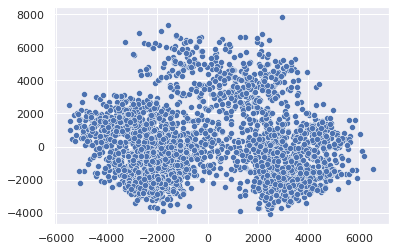

In [ ]:
import seaborn as sns
sns.set_theme()

sns.scatterplot(x=df_2d[:, 0], y = df_2d[:, 1])

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans

cl = AgglomerativeClustering(n_clusters=7)

In [ ]:
cl_labels = cl.fit_predict(df_small[df_small.columns[:-1]])

In [ ]:
sns.set_theme()

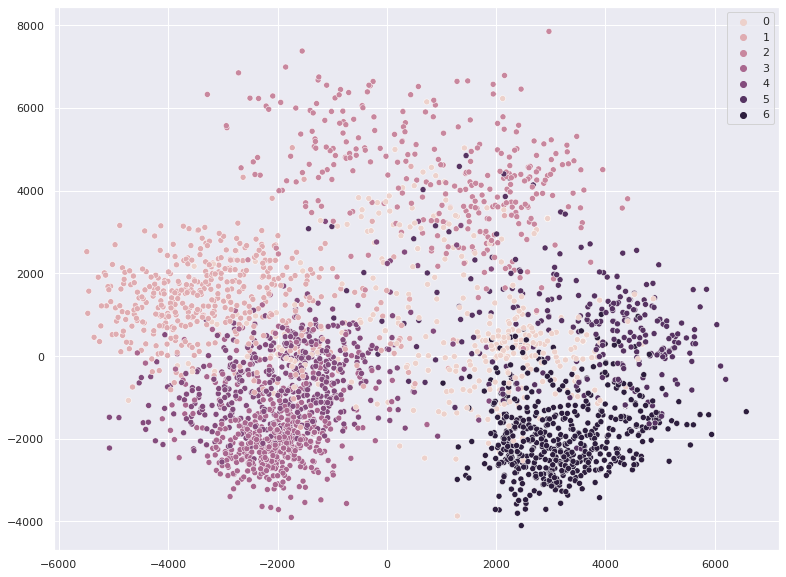

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.scatterplot(ax=ax, x=df_2d[:, 0], y = df_2d[:, 1], hue=cl_labels)